# Full Models

**Goals:** 

1. Play with the dimension uniformity of the three layers
2. Use the uniform dimension layers to train our first 3d CNN model!
3. Then look at conv2d + LSTM


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import FCNet, CNN_3d, layer0_12x12, layer2_12x12
from train import check_accuracy, train
from plottingFcts import trainingMetrics, sigBkgEff, plotROC, plotConfusion

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=256)

In [3]:
myModel = CNN_3d()

Output size after the first conv: 16,2.0,6.0,6.0
Output size after the second conv: 8,1.0,4.0,4.0


In [4]:
myModel.modelName

'cnn3d_12x12_C16_F344_S222_P111_C8_F222_S122_P011_fc_50_25_dpt_0.5'

**Sanity check:**
Look at the model accuracy before you start training!

In [5]:
check_accuracy(loader_val, myModel)

Got 8761 / 30000 correct (29.20)


Perfect, close to 33%, as expected!

Next, checkt the size of the output.

In [6]:
for t, (l0, l1, l2, y) in enumerate(loader_train):
#     l0_12x12 = layer0_12x12(l0)
#     print("l0:",l0_12x12.shape)
    
#     print(l2.shape)
#     l2_12x12 = layer2_12x12(l2)
#     print("l2:",l2_12x12.shape)
    
    cnn_out = myModel(l0,l1,l2)
    print(cnn_out.shape)
    
    break

torch.Size([256, 3])


Sanity check: I want to make sure that I'm stitching the models together correctly, so check the parameters of the uniforming dimensionalaity layers so that I have a baseline that I can check against again after I'm done with the training.

In [7]:
print('Parameters in layer0_12x12:')
for p in list(layer0_12x12.parameters()):
    print(p)
    
print('\nParameters in layer2_12x12:')
for p in list(layer2_12x12.parameters()):
    print(p)

Parameters in layer0_12x12:
Parameter containing:
tensor([[[[-0.1183,  0.1374, -0.1892,  0.1170, -0.1742,  0.2349, -0.1880,
           -0.2349]]]])
Parameter containing:
tensor([ 0.1196])
Parameter containing:
tensor([[[[-0.4462],
          [ 0.0358],
          [ 0.3421],
          [ 0.1411]]]])
Parameter containing:
tensor([ 0.4301])

Parameters in layer2_12x12:
Parameter containing:
tensor([[[[ 0.4192, -0.1962]]]])
Parameter containing:
tensor(1.00000e-02 *
       [ 4.4798])


## Train the model

Ok, this is exciting!!

In [21]:
optimizer = optim.Adam(myModel.parameters(), lr = 0.00001)

In [23]:
history, myModel = train(loader_train, loader_val, myModel, optimizer, epochs=5, returnBest=True)


Epoch 1/5:
Iteration 0, loss = 0.4784
Got 21917 / 30000 correct (73.06)

Iteration 100, loss = 0.5656
Got 21931 / 30000 correct (73.10)

Iteration 200, loss = 0.5049
Got 22008 / 30000 correct (73.36)

Iteration 300, loss = 0.5155
Got 21984 / 30000 correct (73.28)

Iteration 400, loss = 0.5432
Got 22044 / 30000 correct (73.48)

Iteration 500, loss = 0.4646
Got 22067 / 30000 correct (73.56)

Iteration 600, loss = 0.4915
Got 22025 / 30000 correct (73.42)

Iteration 700, loss = 0.5364
Got 22072 / 30000 correct (73.57)

Got 132359 / 180000 correct (73.53)
Got 22003 / 30000 correct (73.34)

Epoch 2/5:
Iteration 0, loss = 0.4936
Got 22082 / 30000 correct (73.61)

Iteration 100, loss = 0.4806
Got 22011 / 30000 correct (73.37)

Iteration 200, loss = 0.4877
Got 22063 / 30000 correct (73.54)

Iteration 300, loss = 0.4884
Got 21988 / 30000 correct (73.29)

Iteration 400, loss = 0.4282
Got 22041 / 30000 correct (73.47)

Iteration 500, loss = 0.4542
Got 22014 / 30000 correct (73.38)

Iteration 600,

In [24]:
print('Parameters in layer0_12x12:')
for p in list(layer0_12x12.parameters()):
    print(p)
    
print('\nParameters in layer2_12x12:')
for p in list(layer2_12x12.parameters()):
    print(p)

Parameters in layer0_12x12:
Parameter containing:
tensor([[[[-0.3439, -0.0473, -0.1700,  0.2105, -0.1129,  0.1674, -0.3997,
           -0.3968]]]])
Parameter containing:
tensor(1.00000e-02 *
       [ 3.1895])
Parameter containing:
tensor([[[[-0.3968],
          [ 0.1779],
          [ 0.5330],
          [ 0.3063]]]])
Parameter containing:
tensor([ 0.7334])

Parameters in layer2_12x12:
Parameter containing:
tensor([[[[ 0.4137, -0.6803]]]])
Parameter containing:
tensor([ 0.1673])


These parameter weights are changed from their initial values, so this looks ok!

In [25]:
check_accuracy(loader_val, myModel)

Got 22081 / 30000 correct (73.60)


### Model evaluation metrics

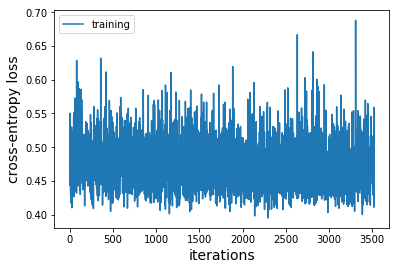

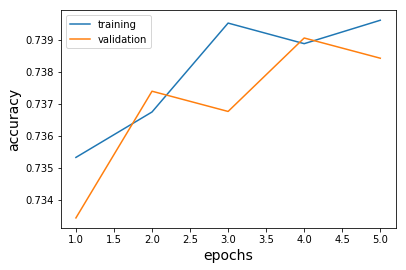

In [26]:
trainingMetrics(history)

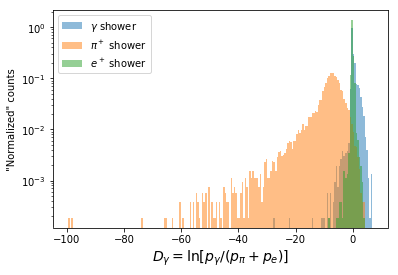

../plottingFcts.py:229: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


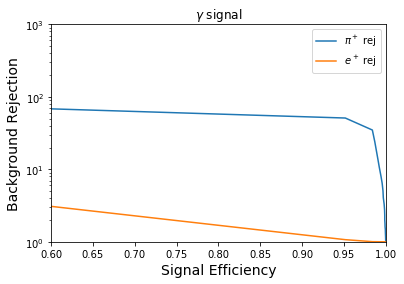

../plottingFcts.py:103: RuntimeWarning: overflow encountered in true_divide
  disc = np.log(np.divide(predictions[:,1], predictions[:,0] + predictions[:,2]))


ValueError: range parameter must be finite.

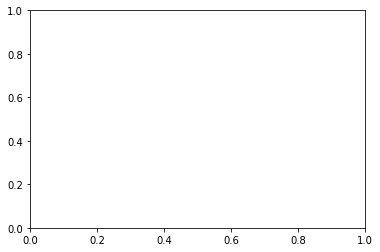

In [28]:
particles = ['gamma','pi','e']

for node in range(3):
    g_eff, pi_eff, e_eff = sigBkgEff(myModel, loader_val, node)
    mTag = '{}-sig_{}'.format(particles[node], myModel.modelName)
    
    # Plot the ROC curve using node as the signal and the other two as the bkg
    if node == 0:
        plotROC([g_eff, g_eff], [pi_eff, e_eff], ['$\pi^+$ rej', '$e^+$ rej'], title='$\gamma$ signal', tag=mTag)
    if node == 1:
        plotROC([pi_eff, pi_eff], [g_eff, e_eff], ['$\gamma$ rej', '$e^+$ rej'], title='$\pi^+$ signal', tag=mTag)
    elif node == 2:
        plotROC([e_eff, e_eff], [g_eff, pi_eff], ['$\gamma$ rej', '$\pi^+$ rej'], title='$e^+$ signal', tag=mTag)
        

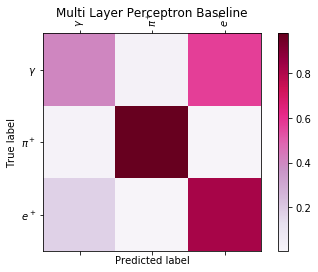

In [29]:
plotConfusion(myModel, loader_val, title="Multi Layer Perceptron Baseline")

# Recurrent CNN

- Apply three 2d convolutions to get a fixed size for the image vector!